In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import os

warnings.simplefilter('ignore')

In [5]:
dividends_df = {}

def max_DD(x):
    i = np.argmax(np.maximum.accumulate(x) - x) 
    j = np.argmax(x[:i]) 
    return (x[i] - x[j])


def load_dividends():
    
    global dividends_df
    
    sectors_info = pd.read_csv("sectors.csv")
    tickers = sectors_info["TICKER"].values
    
    for ticker in tickers:
        
        try:
            div_df = pd.read_csv(os.path.join(os.path.abspath("div_data"),\
                                                       ticker+".csv"))
            div_df.index = pd.to_datetime(div_df["Ex-Date"])
            dividends_df[ticker] = div_df
        except Exception as e:
            pass


def momentum_ribbons(comm_coef = 10.0/10000.0, ticker = "ADSK"):
    
    market_data_original = pd.read_csv("market_data_daily_resample_close.csv",\
                                       index_col = 0).ffill()
    asset = market_data_original[ticker]
    
    rolling_means = {}

    for i in np.linspace(10, 100, 10):
        cur_roll_mean = asset.rolling(window=int(i),center=False).mean()
        rolling_means[i] = cur_roll_mean
        
    rolling_means = pd.DataFrame(rolling_means).dropna()
    plt.show()
    
    
    scores = pd.Series(index=market_data_original.index)
    active_dates = pd.to_datetime(scores.index)
    
    for date in rolling_means.index:
        mavg_values = rolling_means.loc[date]
        ranking = stats.rankdata(mavg_values.values)
        d, _ = stats.spearmanr(ranking, range(1, 11))
        scores[date] = d
            
    (scores).plot(figsize=(16, 8), alpha=0.6);
    plt.legend(['Signal'], bbox_to_anchor=(1, 0.9))
    asset.plot(secondary_y=True, alpha=1)
    plt.legend(['Asset Price'], bbox_to_anchor=(1, 1))
    plt.show()
    
#    asset.index = pd.to_datetime(asset.index)
    asset.index = asset.index.union(scores.index)
    asset = asset.ffill()
    
    total_return = 1.0
    open_positions_long = []
    open_positions_short = []
    pos_frac = 0.1
    bottom_visited = 0
    top_visited = 0
    last_annual_return = 1.0
    annual_returns = []

    
    returns_history = []
    
    for j in range(len(scores.index)):
        
        date = pd.to_datetime(scores.index[j])
        return_add_long = .0
        return_add_short = .0
        realized = .0
        score_cur = scores.iloc[j]
        px_cur = asset.loc[scores.index[j]]
        
        for pos in open_positions_short:
                    
            px_open = pos[0]
            pos_size = pos[1]
            return_add_short += pos_size * (-px_cur + px_open) / px_open -\
                    pos_size * comm_coef
                    
            if ticker in dividends_df.keys():
                    
                    if date in dividends_df[ticker].index:
                        
                        if dividends_df[ticker].loc[date]["Dividend Type"] == "Regular Cash":

                            realized -= dividends_df[ticker].loc[date]["Dividend Amount"]\
                                        / px_open
                    
        for pos in open_positions_long:
                    
            px_open = pos[0]
            pos_size = pos[1]
            return_add_long += pos_size * (px_cur - px_open) / px_open -\
                    pos_size * comm_coef
                    
            if ticker in dividends_df.keys():
                    
                    if date in dividends_df[ticker].index:
                        
                        if dividends_df[ticker].loc[date]["Dividend Type"] == "Regular Cash":

                            realized += dividends_df[ticker].loc[date]["Dividend Amount"]\
                                        / px_open
                    
        
        if score_cur > 0.85 and bottom_visited == 0:
            
                
            bottom_visited = 1
            open_positions_short = []
                
            open_positions_long.append((px_cur, pos_frac * total_return))
            return_add_long -= pos_frac * total_return * comm_coef
            realized += return_add_short
            return_add_short = .0
            top_visited = 0
            
        if score_cur < -0.85 and top_visited == 0:

            top_visited = 1
            open_positions_long = []            
                
            open_positions_short.append((px_cur, pos_frac * total_return))   
            return_add_short -= pos_frac * total_return * comm_coef
            realized += return_add_long
            return_add_long = .0
            bottom_visited = 0
            
        total_return += realized
        returns_history.append(total_return + return_add_long +\
                               return_add_short)
        
        if (date.month == 4) and (date.day == 1):
            
            annual_returns.append(total_return / last_annual_return)
            last_annual_return = total_return
        
    returns_history_series = pd.Series(data = returns_history, index = scores.index)
    returns_history_series.plot(figsize=(13, 6), alpha=0.6, grid = True)
    plt.legend(['Total return, ' + "ADSK"], bbox_to_anchor=(1, 1))
    
    DD = max_DD(returns_history)
    calmar_ratio = returns_history[-1] / (.0 + np.abs(DD))
    CAGR = pow(returns_history[-1], 1.0/((active_dates[-1] - active_dates[0]).days\
               / 365.0)) - 1.0
    MAR_ratio = CAGR / (.0 + np.abs(DD))
    sharpe = np.mean(annual_returns) / np.std(annual_returns)
    
    print("Calmar ratio: ", calmar_ratio, ", MAR ratio: ", MAR_ratio)

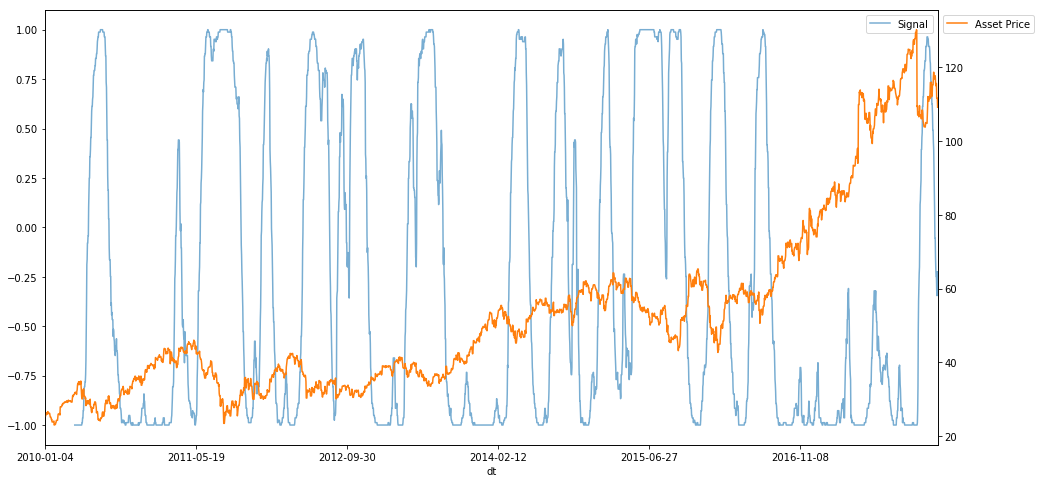

Calmar ratio:  9.093606375440787 , MAR ratio:  0.11637547875309624


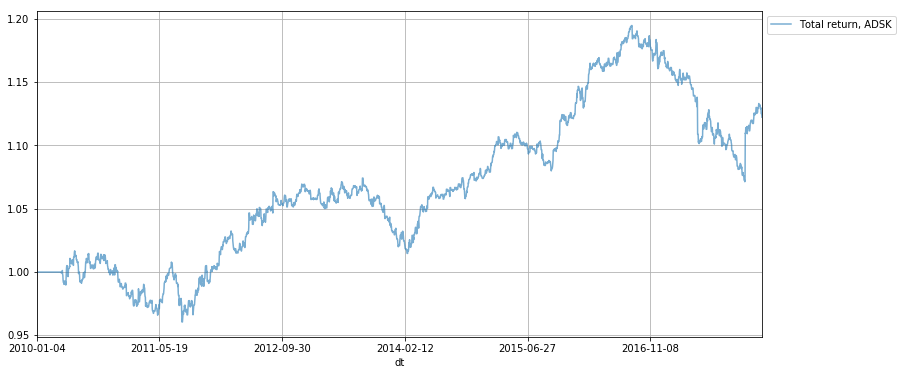

In [6]:
load_dividends()
momentum_ribbons()